# Comparaison Multi-Stratégies : Fixed vs Adaptive

Ce notebook permet de comparer plusieurs configurations de la stratégie Envelope :
- **Baseline** : Paramètres fixes (configuration actuelle)
- **Regime Adaptive** : Adaptation selon le régime de marché (BULL/BEAR/RECOVERY)
- **Custom** : Vos propres adaptations

Le système génère automatiquement un rapport comparatif avec recommandation.

## 1️⃣ Configuration et chargement des données

In [1]:
import sys
sys.path.append('../..')

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Backtest engine
from utilities.strategies.envelopeMulti_v2 import EnvelopeMulti_v2
from utilities.data_manager import ExchangeDataManager

# Système adaptatif
from core import calculate_regime_series, DEFAULT_PARAMS
from core.params_adapter import FixedParamsAdapter, RegimeBasedAdapter
from core.backtest_comparator import BacktestComparator

c:\Users\jacks\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Configuration du backtest
BACKTEST_LEVERAGE = 10
START_DATE = "2020-01-01"  # Couvre tous les cycles: BULL 2020-2021, BEAR 2022, BULL 2023-2024
END_DATE = "2025-10-03"

# Échantillon stratifié de 8 paires représentatives
# (au lieu de 3 pour couvrir différents profils de marché)
params_live = {
    # Majors (faible volatilité, référence marché)
    "BTC/USDT:USDT": {"size": 0.1, "ma_base_window": 7, "envelopes": [0.07, 0.1, 0.15]},
    "ETH/USDT:USDT": {"size": 0.1, "ma_base_window": 7, "envelopes": [0.07, 0.1, 0.15]},
    
    # Mid-caps (volatilité moyenne)
    "SOL/USDT:USDT": {"size": 0.1, "ma_base_window": 7, "envelopes": [0.07, 0.1, 0.15]},
    "AVAX/USDT:USDT": {"size": 0.1, "ma_base_window": 7, "envelopes": [0.07, 0.1, 0.15]},
    "ADA/USDT:USDT": {"size": 0.1, "ma_base_window": 7, "envelopes": [0.07, 0.1, 0.15]},
    
    # Volatiles (haute volatilité, beaucoup de trades)
    "DOGE/USDT:USDT": {"size": 0.1, "ma_base_window": 7, "envelopes": [0.07, 0.1, 0.15]},
    "SUSHI/USDT:USDT": {"size": 0.1, "ma_base_window": 7, "envelopes": [0.07, 0.1, 0.15]},
    
    # Low performers (pour tester robustesse)
    "TRX/USDT:USDT": {"size": 0.1, "ma_base_window": 7, "envelopes": [0.07, 0.1, 0.15]},
}

# Classification par profil
PAIR_CLASSES = {
    "BTC/USDT:USDT": "major",
    "ETH/USDT:USDT": "major",
    "SOL/USDT:USDT": "mid-cap",
    "AVAX/USDT:USDT": "mid-cap",
    "ADA/USDT:USDT": "mid-cap",
    "DOGE/USDT:USDT": "volatile",
    "SUSHI/USDT:USDT": "volatile",
    "TRX/USDT:USDT": "low",
}

# Conversion pour backtest (diviser size par leverage)
params_coin = {}
for pair, p in params_live.items():
    params_coin[pair] = {
        "ma_base_window": p["ma_base_window"],
        "envelopes": p["envelopes"],
        "src": "close",
        "size": p["size"] / BACKTEST_LEVERAGE  # Ajustement pour V2 engine
    }

print("✅ Configuration chargée")
print(f"   Paires: {len(params_coin)} (échantillon stratifié)")
print(f"   - Majors: {sum(1 for c in PAIR_CLASSES.values() if c == 'major')}")
print(f"   - Mid-caps: {sum(1 for c in PAIR_CLASSES.values() if c == 'mid-cap')}")
print(f"   - Volatiles: {sum(1 for c in PAIR_CLASSES.values() if c == 'volatile')}")
print(f"   - Low performers: {sum(1 for c in PAIR_CLASSES.values() if c == 'low')}")
print(f"   Période: {START_DATE} → {END_DATE} (BULL 2020-21, BEAR 2022, BULL 2023-24)")
print(f"   Leverage: {BACKTEST_LEVERAGE}x")

✅ Configuration chargée
   Paires: 8 (échantillon stratifié)
   - Majors: 2
   - Mid-caps: 3
   - Volatiles: 2
   - Low performers: 1
   Période: 2020-01-01 → 2024-12-31 (BULL 2020-21, BEAR 2022, BULL 2023-24)
   Leverage: 10x


In [3]:
# Chargement des données
exchange = ExchangeDataManager(
    exchange_name="bitget",
    path_download="../database/exchanges"
)

df_list = {}
for pair in params_coin.keys():
    print(f"Chargement {pair}...")
    df = exchange.load_data(pair, "1h", start_date=START_DATE, end_date=END_DATE)
    df_list[pair] = df

oldest_pair = min(df_list, key=lambda p: df_list[p].index.min())
print(f"\n✅ Données chargées. Paire la plus ancienne: {oldest_pair}")

Chargement BTC/USDT:USDT...
Chargement ETH/USDT:USDT...
Chargement SOL/USDT:USDT...
Chargement AVAX/USDT:USDT...
Chargement ADA/USDT:USDT...
Chargement DOGE/USDT:USDT...
Chargement SUSHI/USDT:USDT...
Chargement TRX/USDT:USDT...

✅ Données chargées. Paire la plus ancienne: BTC/USDT:USDT


In [4]:
# Détection du régime sur BTC (proxy global)
df_btc = exchange.load_data("BTC/USDT:USDT", "1h", start_date=START_DATE, end_date=END_DATE)
regime_series = calculate_regime_series(df_btc, confirm_n=12)

# Distribution des régimes
print("📊 Distribution des régimes détectés:")
regime_counts = regime_series.value_counts(normalize=True) * 100
for regime, pct in regime_counts.items():
    print(f"   {regime.name}: {pct:.1f}%")

📊 Distribution des régimes détectés:
   BULL: 48.1%
   BEAR: 39.3%
   RECOVERY: 12.6%


## 2️⃣ Définition des stratégies à comparer

In [5]:
# Liste des adaptateurs à tester
adapters = {
    "Baseline (Fixed)": FixedParamsAdapter(params_coin),
    
    "Regime Adaptive": RegimeBasedAdapter(
        base_params=params_coin,
        regime_series=regime_series,
        regime_params=DEFAULT_PARAMS,
        multipliers={'envelope_std': True},
        base_std=0.10
    ),
    
    # Ajouter d'autres configurations ici...
    # "Conservative": RegimeBasedAdapter(..., base_std=0.08),
    # "Aggressive": RegimeBasedAdapter(..., base_std=0.12),
}

print(f"✅ {len(adapters)} stratégies configurées:")
for name, adapter in adapters.items():
    print(f"   - {name}: {adapter.get_description()}")

✅ 2 stratégies configurées:
   - Baseline (Fixed): Fixed parameters (baseline)
   - Regime Adaptive: Regime-based adaptation (envelope_std)


## 3️⃣ Exécution des backtests

In [6]:
# Comparateur
comparator = BacktestComparator(initial_wallet=1000)

# Paramètres communs
backtest_params = {
    "initial_wallet": 1000,
    "leverage": BACKTEST_LEVERAGE,
    "maker_fee": 0.0002,
    "taker_fee": 0.0006,
    "stop_loss": 0.25,
    "reinvest": True,
    "liquidation": True,
    "risk_mode": "scaling",
}

# Exécuter tous les backtests
print("\n🚀 Exécution des backtests...\n")
print("=" * 80)

for strategy_name, adapter in adapters.items():
    print(f"\n▶ {strategy_name}")
    print("-" * 80)
    
    # Initialiser la stratégie
    strategy = EnvelopeMulti_v2(
        df_list=df_list,
        oldest_pair=oldest_pair,
        type=["long", "short"],
        params=params_coin
    )
    
    # Préparer les indicateurs
    strategy.populate_indicators()
    strategy.populate_buy_sell()
    
    # Exécuter avec l'adaptateur
    result = strategy.run_backtest(
        **backtest_params,
        params_adapter=adapter  # 🔑 Adaptation dynamique
    )
    
    # Extraire trades et days du résultat
    df_trades = result['trades']
    df_days = result['days']
    
    # Ajouter au comparateur
    comparator.add_backtest(
        name=strategy_name,
        df_trades=df_trades,
        df_days=df_days,
        metadata={
            "adapter": adapter.get_description(),
            "leverage": BACKTEST_LEVERAGE,
            "period": f"{START_DATE} to {END_DATE}"
        }
    )
    
    # Afficher résultat rapide
    final_wallet = df_days['wallet'].iloc[-1] if len(df_days) > 0 else 1000
    perf = ((final_wallet / 1000) - 1) * 100
    print(f"   Wallet final: ${final_wallet:.2f} ({perf:+.2f}%)")
    print(f"   Trades: {len(df_trades)}")

print("\n" + "=" * 80)
print("✅ Tous les backtests terminés\n")


🚀 Exécution des backtests...


▶ Baseline (Fixed)
--------------------------------------------------------------------------------
   Wallet final: $3273.49 (+227.35%)
   Trades: 2037

▶ Regime Adaptive
--------------------------------------------------------------------------------
   Wallet final: $2392.24 (+139.22%)
   Trades: 2097

✅ Tous les backtests terminés



## 4️⃣ Comparaison et recommandation

In [7]:
# Générer le rapport comparatif
comparator.print_summary()


🔍 COMPARAISON DES BACKTESTS
        Strategy  Final Wallet  Total Perf (%)  Sharpe Ratio  Max DD (%)  Win Rate (%)  N Trades  Avg PnL (%)  Max Win (%)  Max Loss (%)  Total Fees  Avg Exposition  Avg Long Expo  Avg Short Expo  Avg Duration (h)
Baseline (Fixed)   3273.491597       227.34916      3.461041   -3.543498     70.250368      2037     1.285758    12.001710     -9.730426   85.896992       23.736505      14.533887        9.202619          4.550319
 Regime Adaptive   2392.241801       139.22418      2.058420  -14.693148     62.327134      2097     0.865806    14.742303     -9.730426   73.269982       18.384346      11.393610        6.990735          4.383882

--------------------------------------------------------------------------------
✅ RECOMMANDATION: Baseline (Fixed)
--------------------------------------------------------------------------------



In [8]:
# Bootstrap significativité
def bootstrap_sharpe_difference(df_days_adaptive, df_days_fixed, n_bootstrap=1000):
    returns_adaptive = df_days_adaptive['wallet'].pct_change().dropna()
    returns_fixed = df_days_fixed['wallet'].pct_change().dropna()
    min_len = min(len(returns_adaptive), len(returns_fixed))
    returns_adaptive = returns_adaptive.iloc[:min_len]
    returns_fixed = returns_fixed.iloc[:min_len]
    sharpe_diffs = []
    for _ in range(n_bootstrap):
        idx = np.random.choice(len(returns_adaptive), len(returns_adaptive), replace=True)
        sample_a = returns_adaptive.iloc[idx]
        sample_f = returns_fixed.iloc[idx]
        sharpe_a = sample_a.mean() / sample_a.std() * np.sqrt(252*24) if sample_a.std() > 0 else 0
        sharpe_f = sample_f.mean() / sample_f.std() * np.sqrt(252*24) if sample_f.std() > 0 else 0
        sharpe_diffs.append(sharpe_a - sharpe_f)
    sharpe_diffs = np.array(sharpe_diffs)
    uplift = np.mean(sharpe_diffs)
    ci_lower = np.percentile(sharpe_diffs, 2.5)
    ci_upper = np.percentile(sharpe_diffs, 97.5)
    is_significant = ci_lower > 0
    return uplift, ci_lower, ci_upper, is_significant

bt_fixed = [bt for bt in comparator.backtests if "Fixed" in bt.name][0]
bt_adaptive = [bt for bt in comparator.backtests if "Adaptive" in bt.name][0]

uplift, ci_low, ci_high, is_sig = bootstrap_sharpe_difference(bt_adaptive.df_days, bt_fixed.df_days, 1000)

print("📊 BOOTSTRAP SIGNIFICATIVITÉ")
print("=" * 80)
print(f"Uplift Sharpe: {uplift:+.3f}")
print(f"IC 95%: [{ci_low:+.3f}, {ci_high:+.3f}]")
print(f"Significatif: {'✅ OUI' if is_sig else '❌ NON'}")
if is_sig:
    print("✅ L'adaptation améliore significativement le Sharpe")
else:
    print("⚠️  Pas de preuve statistique")
print("=" * 80)

📊 BOOTSTRAP SIGNIFICATIVITÉ
Uplift Sharpe: -5.742
IC 95%: [-8.301, -3.252]
Significatif: ❌ NON
⚠️  Pas de preuve statistique


In [9]:
# Analyse par classe
print("\n📈 ANALYSE PAR CLASSE")
print("=" * 80)

results = []
for pair in params_coin.keys():
    df_tf = bt_fixed.df_trades[bt_fixed.df_trades['pair'] == pair].copy()
    df_ta = bt_adaptive.df_trades[bt_adaptive.df_trades['pair'] == pair].copy()
    for df in [df_tf, df_ta]:
        if len(df) > 0 and 'trade_result' not in df.columns:
            df['trade_result'] = df["close_trade_size"] - df["open_trade_size"] - df["open_fee"] - df["close_fee"]
    pnl_f = df_tf['trade_result'].sum() if len(df_tf) > 0 else 0
    pnl_a = df_ta['trade_result'].sum() if len(df_ta) > 0 else 0
    results.append({'pair': pair, 'class': PAIR_CLASSES[pair], 'delta_pnl': pnl_a - pnl_f})

df_res = pd.DataFrame(results).groupby('class')['delta_pnl'].mean().round(2)
print(df_res)
print(f"\n✅ Meilleure: {df_res.idxmax()} (+${df_res.max():.2f})")
print(f"⚠️  Pire: {df_res.idxmin()} ({df_res.min():+.2f}$)")
print("=" * 80)


📈 ANALYSE PAR CLASSE
class
low         -32.77
major       -93.62
mid-cap    -128.86
volatile   -137.35
Name: delta_pnl, dtype: float64

✅ Meilleure: low (+$-32.77)
⚠️  Pire: volatile (-137.35$)


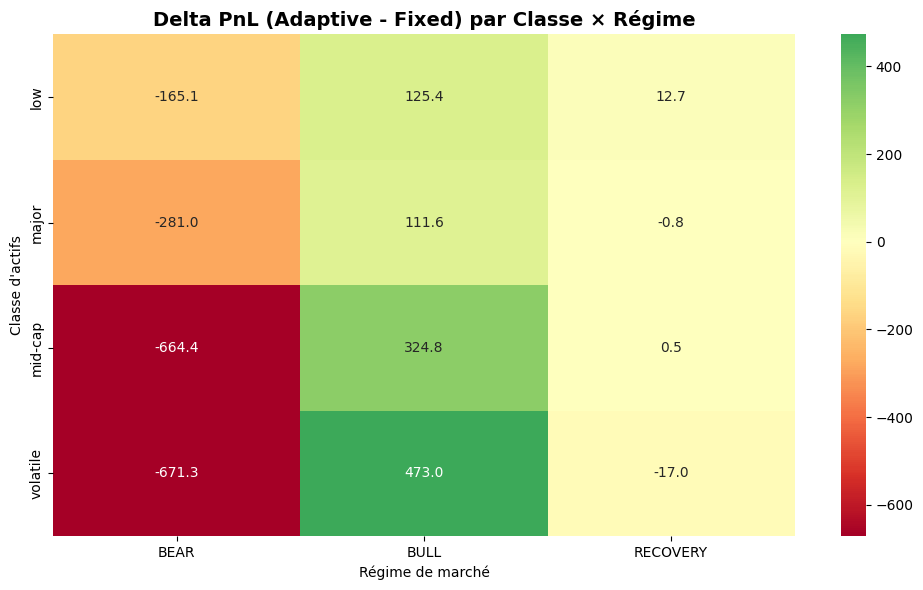


💡 Interprétation:
   - Vert: Adaptive performe mieux que Fixed
   - Rouge: Fixed performe mieux que Adaptive
   - Identifier les classes/régimes où l'adaptation est bénéfique


In [10]:
# Heatmap: Delta PnL par classe × régime
import matplotlib.pyplot as plt
import seaborn as sns
from core import Regime

data = []
for pair in params_coin.keys():
    df_ta = bt_adaptive.df_trades[bt_adaptive.df_trades['pair'] == pair].copy()
    df_tf = bt_fixed.df_trades[bt_fixed.df_trades['pair'] == pair].copy()

    for df in [df_ta, df_tf]:
        if len(df) > 0 and 'trade_result' not in df.columns:
            df['trade_result'] = df["close_trade_size"] - df["open_trade_size"] - df["open_fee"] - df["close_fee"]

    if len(df_ta) > 0:
        df_ta['date'] = pd.to_datetime(df_ta['open_date'])
        df_ta['regime'] = df_ta['date'].map(lambda x: regime_series.asof(x))

    if len(df_tf) > 0:
        df_tf['date'] = pd.to_datetime(df_tf['open_date'])
        df_tf['regime'] = df_tf['date'].map(lambda x: regime_series.asof(x))

    # Use Regime enum instead of string comparison
    for reg_enum, reg_name in [(Regime.BULL, 'BULL'), (Regime.BEAR, 'BEAR'), (Regime.RECOVERY, 'RECOVERY')]:
        if len(df_ta) > 0:
            # Filter by Regime enum value
            pnl_a = df_ta[df_ta['regime'] == reg_enum]['trade_result'].sum()
            dates = df_ta[df_ta['regime'] == reg_enum]['date']
            pnl_f = df_tf[df_tf['date'].isin(dates)]['trade_result'].sum() if len(df_tf) > 0 else 0
            data.append({'class': PAIR_CLASSES[pair], 'regime': reg_name, 'delta': pnl_a - pnl_f})

df_h = pd.DataFrame(data).groupby(['class', 'regime'])['delta'].sum().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(df_h, annot=True, fmt=".1f", cmap='RdYlGn', center=0, ax=ax)
ax.set_title('Delta PnL (Adaptive - Fixed) par Classe × Régime', fontsize=14, fontweight='bold')
ax.set_xlabel('Régime de marché')
ax.set_ylabel("Classe d'actifs")
plt.tight_layout()
plt.show()

print("\n💡 Interprétation:")
print("   - Vert: Adaptive performe mieux que Fixed")
print("   - Rouge: Fixed performe mieux que Adaptive")
print("   - Identifier les classes/régimes où l'adaptation est bénéfique")

In [11]:
# Analyse par classe d'actifs
print("\n📈 ANALYSE PAR CLASSE D'ACTIFS")
print("=" * 80)

# Calculer métriques par paire pour chaque stratégie
results_by_pair = []

for pair in params_coin.keys():
    # Filter trades for this pair
    df_trades_fixed = bt_fixed.df_trades[bt_fixed.df_trades['pair'] == pair].copy()
    df_trades_adaptive = bt_adaptive.df_trades[bt_adaptive.df_trades['pair'] == pair].copy()
    
    # Calculate trade_result if absent
    for df in [df_trades_fixed, df_trades_adaptive]:
        if len(df) > 0 and 'trade_result' not in df.columns:
            df['trade_result'] = (
                df["close_trade_size"] -
                df["open_trade_size"] -
                df["open_fee"] -
                df["close_fee"]
            )
    
    # Métriques
    n_trades_fixed = len(df_trades_fixed)
    n_trades_adaptive = len(df_trades_adaptive)
    
    if n_trades_fixed > 0:
        wr_fixed = (df_trades_fixed['trade_result'] > 0).mean() * 100
        pnl_fixed = df_trades_fixed['trade_result'].sum()
    else:
        wr_fixed = 0
        pnl_fixed = 0
        
    if n_trades_adaptive > 0:
        wr_adaptive = (df_trades_adaptive['trade_result'] > 0).mean() * 100
        pnl_adaptive = df_trades_adaptive['trade_result'].sum()
    else:
        wr_adaptive = 0
        pnl_adaptive = 0
    
    results_by_pair.append({
        'pair': pair,
        'class': PAIR_CLASSES[pair],
        'n_trades_fixed': n_trades_fixed,
        'n_trades_adaptive': n_trades_adaptive,
        'wr_fixed': wr_fixed,
        'wr_adaptive': wr_adaptive,
        'pnl_fixed': pnl_fixed,
        'pnl_adaptive': pnl_adaptive,
        'delta_pnl': pnl_adaptive - pnl_fixed,
        'delta_wr': wr_adaptive - wr_fixed,
    })

df_pair_analysis = pd.DataFrame(results_by_pair)

# Aggregate by class
df_class_analysis = df_pair_analysis.groupby('class').agg({
    'delta_pnl': 'mean',
    'delta_wr': 'mean',
    'n_trades_adaptive': 'sum',
}).round(2)

print(f"\nDelta performance (Adaptive - Fixed) par classe:")
print(df_class_analysis.to_string())

# Identify best/worst classes
best_class = df_class_analysis['delta_pnl'].idxmax()
worst_class = df_class_analysis['delta_pnl'].idxmin()

print(f"\n✅ Meilleure classe avec Adaptive: {best_class} (+${df_class_analysis.loc[best_class, 'delta_pnl']:.2f})")
print(f"⚠️  Pire classe avec Adaptive: {worst_class} ({df_class_analysis.loc[worst_class, 'delta_pnl']:+.2f}$)")

print("\n" + "=" * 80)


📈 ANALYSE PAR CLASSE D'ACTIFS

Delta performance (Adaptive - Fixed) par classe:
          delta_pnl  delta_wr  n_trades_adaptive
class                                           
low          -32.77     -6.64                207
major        -93.62     -9.80                277
mid-cap     -128.86     -8.88                752
volatile    -137.35     -7.31                861

✅ Meilleure classe avec Adaptive: low (+$-32.77)
⚠️  Pire classe avec Adaptive: volatile (-137.35$)



In [12]:
# Voir le classement par métrique spécifique
print("\n📊 Top stratégies par Sharpe Ratio:")
print(comparator.rank('Sharpe Ratio')[['Strategy', 'Sharpe Ratio', 'Total Perf (%)', 'Max DD (%)']].head())


📊 Top stratégies par Sharpe Ratio:
           Strategy  Sharpe Ratio  Total Perf (%)  Max DD (%)
0  Baseline (Fixed)      3.461041       227.34916   -3.543498
1   Regime Adaptive      2.058420       139.22418  -14.693148


In [13]:
# Sauvegarder les résultats
output_path = "backtest_comparison_results.csv"
comparator.save_comparison(output_path)
print(f"\n💾 Résultats complets sauvegardés: {output_path}")

✅ Comparaison sauvegardée: backtest_comparison_results.csv

💾 Résultats complets sauvegardés: backtest_comparison_results.csv


## 5️⃣ Analyse détaillée (optionnel)

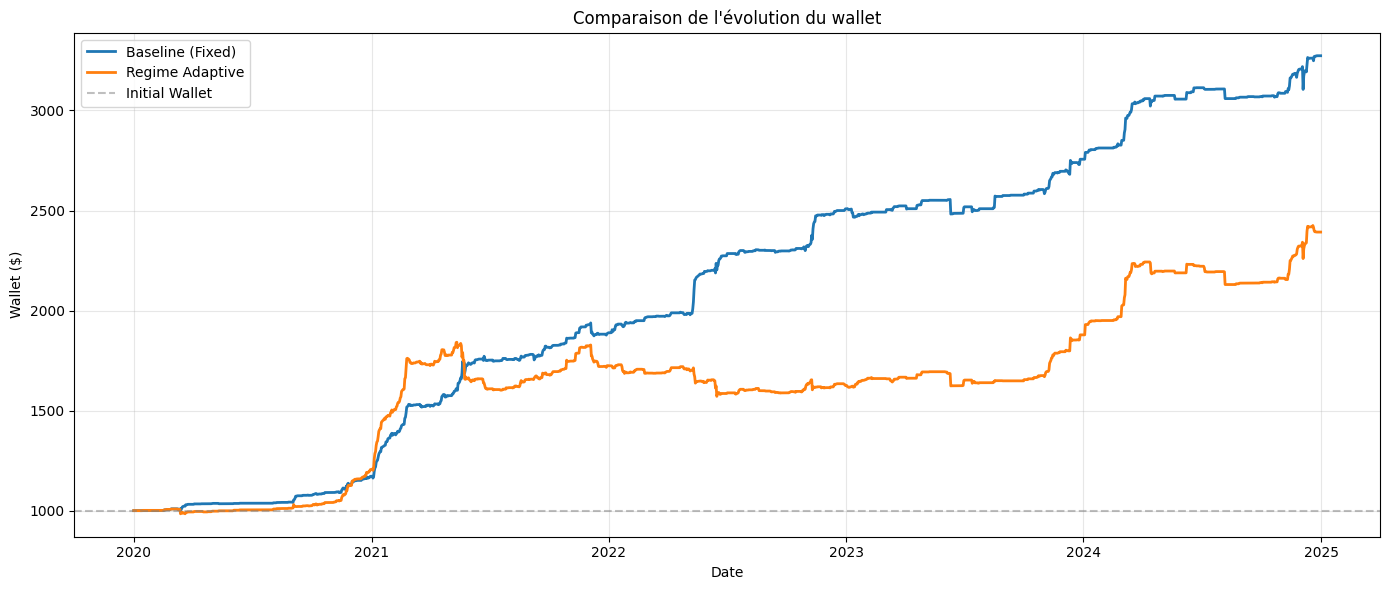

In [14]:
# Visualiser l'évolution du wallet pour chaque stratégie
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

for bt in comparator.backtests:
    df_days = bt.df_days.copy()
    if len(df_days) > 0:
        df_days['date'] = pd.to_datetime(df_days['day'])
        plt.plot(df_days['date'], df_days['wallet'], label=bt.name, linewidth=2)

plt.axhline(y=1000, color='gray', linestyle='--', alpha=0.5, label='Initial Wallet')
plt.xlabel('Date')
plt.ylabel('Wallet ($)')
plt.title('Comparaison de l\'évolution du wallet')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 🎯 Conclusion

- Le tableau comparatif montre toutes les métriques clés
- La recommandation est basée sur un score composite pondéré
- Vous pouvez facilement ajouter de nouvelles stratégies dans la section 2️⃣
- Les résultats sont automatiquement sauvegardés en CSV

**Next steps:**
1. Ajuster les pondérations du score selon vos priorités
2. Tester sur différentes périodes
3. Créer des adaptateurs custom avec votre propre logique